## Recommending Solutionset for Technical tickets

In [207]:
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import combinations
import operator


import time
import datetime

import pickle
import matplotlib
import matplotlib.patches as patches
import matplotlib.colors as colors
from palettable.colorbrewer import diverging, qualitative, sequential
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx
import nxviz as nv
from nxviz import CircosPlot
from nxviz import ArcPlot
from nxviz import MatrixPlot
import pydot
import graphviz

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import TweetTokenizer
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from collections import defaultdict
import spacy
from polyglot.text import Text
import itertools

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#resetting max-columns to be displayed to None.
pd.set_option('display.max_columns', None)

In [2]:
#Reading ticket data
ticket_resolution = pd.read_excel("BVOIP Ticket Log Info.xls",sheet_name = "Ticket_resolution")
ticket_logs = pd.read_excel("BVOIP Ticket Log Info.xls",sheet_name = "Ticket_logs")


In [3]:
#Review ticket resolutions
ticket_resolution.head()

,Ticket,Ticket_Opened,Ticket_State,Update_Count,Lock_Count,Ticket_Type_Desc_Tx,Trouble_Description,Problem_Abstract,Trouble_Rept_Desc_Tx,Rept_Svc_Impact_Flag_Desc_Tx,Rept_Request_Desc_Tx,Rept_Svc_Line_Desc_Tx,Resol_Svc_Impact_Flag_Desc_Tx,Resol_Request_Desc_Tx,Resol_Svc_Line_Desc_Tx,Resolution_Product,Svc_Comp_Desc_Tx,Resol_Action_Desc_Tx,Resol_Item_Desc_Tx,Root_Cause_Desc_Tx,Sub_Root_Cause_Desc_Tx,Resolution_Text,Remediation,Resolution_Org,Fault_Caused_By_Change,Percent_Functionality_Impacted,First_Tier_Support,Customer_Care_Description,Resolution_Set_Name,Billing_Indicator,Client_Satisfied,Dispatch_Text
0,189785518,2014-09-04 15:45:31,Closed,5,18,Web,Other,"SCP CONNECTICUT MIGRATION ONLY | IP14068201, I...",System to System Interfaces,No,Fault,BVOIP,Yes,Fault,Application,NaN,Application,Restored Manually,Application,Application,Bad Module,NaN,NaN,NaN,0.0,NaN,NaN,NaN,HD - Workaround,Not billable- under maintenance contract,0,No
1,191142401,2014-10-04 09:58:55,Closed,31,442,Client,Other,Both internet and phones are not working: Stat...,Circuit,Yes,Fault,BVOIP,No,Informational,MIS,NaN,Other,DUP,Not Applicable,Duplicate,Duplicate Ticket,"Duplicate tkt, Refer tkt 000000194322782",NaN,NaN,NaN,NaN,NaN,NaN,BVOIP 3100 Duplicate Ticket 2109,Not billable- In Scope,2,No
2,191142431,2014-10-04 09:54:52,Closed,31,990,Client,Other,Both internet and phones are not working: Static,Other,Yes,Fault,BVOIP,No,Informational,MIS,NaN,Other,DUP,Not Applicable,DUP,Not Applicable,"Duplicate tkt, Refer tkt 000000194322782",NaN,NaN,NaN,NaN,NaN,NaN,MIS 300 Duplicate Ticket 309,Not billable- In Scope,2,No
3,191323389,2014-10-08 16:42:09,Closed,33,2623,Web,Other,Loos of data and voice 4 times this week,Other,Yes,Fault,BVOIP,Yes,Fault,MIS,NaN,Software,Configured,Router,System Software,Configuration,Resolved/IOS upgraded,NaN,NaN,NaN,NaN,NaN,NaN,BVOIP 2100 Router VoIP Software/Configuration ...,Not billable- under maintenance contract,2,No
4,192198046,2014-10-27 22:04:50,Closed,23,128,Auto Detect,Alarm,Caller id for VTN participant from VTN confere...,Other,No,Fault,BVOIP,No,Informational,VOIP,NaN,Other,Task Completed,Task Completed,Task Assigned,Not Applicable,NaN,NaN,NaN,0.0,NaN,NaN,NaN,VoIP - Task Completed,Not billable- In Scope,2,No


In [4]:
#Review ticket logs
ticket_logs.head()

,Ticket,Ticket_Opened,Ticket_State,Ticket_Log_Parse.Active_Org,Outcome,Ticket_Last_Modified_Date,User_Name,User_Phone,Ticket_Message
0,189785518,2014-09-04 15:45:31,Closed,IT-ENTRPRS-SDEL,NaN,2014-09-04 15:45:33,Marilyn Lenoir,7707503728,Application: USRP-IP\nProblem: SCP CONNECTICUT...
1,189785518,2014-09-04 15:45:31,Closed,IT-ENTRPRS-SDEL,NaN,2014-09-22 21:59:43,Twinkle Mahopatra,7707503728,"Hi Marilyn,\nPlease advice if we can close thi..."
2,189785518,2014-09-04 15:45:31,Closed,IT-ENTRPRS-SDEL,NaN,2014-11-28 16:47:18,Sumana Guttikonda,7707503728,Any updates on this? Can this ticket be closed...
3,189785518,2014-09-04 15:45:31,Closed,IT-ENTRPRS-SDEL,NaN,2015-01-23 19:39:31,Sumana Guttikonda,7707503728,Setting ticket to RTC according to user:\n\nMa...
4,189785518,2014-09-04 15:45:31,Closed,IT-ENTRPRS-SDEL,NaN,2015-01-23 19:42:33,Sumana Guttikonda,NaN,\nTicket resolved with Resolution Set: HD - Wo...


In [5]:
#appending log message with date and time

ticket_logs["log"] = ticket_logs.apply(lambda row: "".join(["{[Date: ",str(row["Ticket_Last_Modified_Date"])," ][Org: ",row["Ticket_Log_Parse.Active_Org"]," ][Message: ",row["Ticket_Message"]," ]}"]),axis = 1)
ticket_logs.sort_values(by=["Ticket","Ticket_Last_Modified_Date"],ascending = False,inplace = True)
ticket_logs.reset_index(drop=True,inplace=True)
ticket_logs.head()

,Ticket,Ticket_Opened,Ticket_State,Ticket_Log_Parse.Active_Org,Outcome,Ticket_Last_Modified_Date,User_Name,User_Phone,Ticket_Message,log
0,196088742,2015-01-28 23:57:07,Closed,MO-BGTN-APPL,NaN,2015-01-28 23:57:44,RUBY_VOIP,NaN,Ticket closed by RUBY \nTicket has been Closed...,{[Date: 2015-01-28 23:57:44 ][Org: MO-BGTN-APP...
1,196088742,2015-01-28 23:57:07,Closed,MO-BGTN-APPL,NaN,2015-01-28 23:57:23,RUBY_VOIP,NaN,Updated Ticket,{[Date: 2015-01-28 23:57:23 ][Org: MO-BGTN-APP...
2,196088742,2015-01-28 23:57:07,Closed,MO-BGTN-APPL,NaN,2015-01-28 23:57:08,RUBY_VOIP,NaN,VoIP Ruby Test.\nAlarm: Check2: 142248942126146,{[Date: 2015-01-28 23:57:08 ][Org: MO-BGTN-APP...
3,196088250,2015-01-28 23:48:07,Closed,MO-BGTN-APPL,NaN,2015-01-28 23:48:57,RUBY_VOIP,NaN,Ticket closed by RUBY \nTicket has been Closed...,{[Date: 2015-01-28 23:48:57 ][Org: MO-BGTN-APP...
4,196088250,2015-01-28 23:48:07,Closed,MO-BGTN-APPL,NaN,2015-01-28 23:48:22,RUBY_VOIP,NaN,Updated Ticket,{[Date: 2015-01-28 23:48:22 ][Org: MO-BGTN-APP...


In [6]:
#filling "NaN" values with string "UnKnown" as all these unknown values are missing user "text" inputs.
ticket_resolution.fillna("UnKnown",inplace = True)

#removing duplicate tickets from list of tickets
ticket_resolution = ticket_resolution[ticket_resolution.Root_Cause_Desc_Tx.apply(lambda x:x not in ["Duplicate","DUP"])]
ticket_resolution.reset_index(drop = True,inplace=True)
#copying last modified date for each ticket from ticket_logs
ticket_resolution["last_modified_date"] = ticket_resolution.apply(lambda row: max(ticket_logs[ticket_logs.Ticket == row["Ticket"]]["Ticket_Last_Modified_Date"]),axis=1)

#calculating fix_time for each ticket
ticket_resolution["fix_days"] = ticket_resolution.apply((lambda row: (row["last_modified_date"]-row["Ticket_Opened"]).days),axis=1)

#appending all log_text_message details to ticket
ticket_resolution["ticket_log_message"] = ticket_resolution.apply(lambda row: ";".join(ticket_logs[ticket_logs.Ticket == row["Ticket"]]["log"]),axis = 1)

ticket_resolution.head()

,Ticket,Ticket_Opened,Ticket_State,Update_Count,Lock_Count,Ticket_Type_Desc_Tx,Trouble_Description,Problem_Abstract,Trouble_Rept_Desc_Tx,Rept_Svc_Impact_Flag_Desc_Tx,Rept_Request_Desc_Tx,Rept_Svc_Line_Desc_Tx,Resol_Svc_Impact_Flag_Desc_Tx,Resol_Request_Desc_Tx,Resol_Svc_Line_Desc_Tx,Resolution_Product,Svc_Comp_Desc_Tx,Resol_Action_Desc_Tx,Resol_Item_Desc_Tx,Root_Cause_Desc_Tx,Sub_Root_Cause_Desc_Tx,Resolution_Text,Remediation,Resolution_Org,Fault_Caused_By_Change,Percent_Functionality_Impacted,First_Tier_Support,Customer_Care_Description,Resolution_Set_Name,Billing_Indicator,Client_Satisfied,Dispatch_Text,last_modified_date,fix_days,ticket_log_message
0,189785518,2014-09-04 15:45:31,Closed,5,18,Web,Other,"SCP CONNECTICUT MIGRATION ONLY | IP14068201, I...",System to System Interfaces,No,Fault,BVOIP,Yes,Fault,Application,UnKnown,Application,Restored Manually,Application,Application,Bad Module,UnKnown,UnKnown,UnKnown,0,UnKnown,UnKnown,UnKnown,HD - Workaround,Not billable- under maintenance contract,0,No,2015-01-28 19:44:13,146,{[Date: 2015-01-28 19:44:13 ][Org: IT-ENTRPRS-...
1,191323389,2014-10-08 16:42:09,Closed,33,2623,Web,Other,Loos of data and voice 4 times this week,Other,Yes,Fault,BVOIP,Yes,Fault,MIS,UnKnown,Software,Configured,Router,System Software,Configuration,Resolved/IOS upgraded,UnKnown,UnKnown,UnKnown,UnKnown,UnKnown,UnKnown,BVOIP 2100 Router VoIP Software/Configuration ...,Not billable- under maintenance contract,2,No,2015-01-28 20:30:14,112,{[Date: 2015-01-28 20:30:14 ][Org: GU-GCSC-BVP...
2,192198046,2014-10-27 22:04:50,Closed,23,128,Auto Detect,Alarm,Caller id for VTN participant from VTN confere...,Other,No,Fault,BVOIP,No,Informational,VOIP,UnKnown,Other,Task Completed,Task Completed,Task Assigned,Not Applicable,UnKnown,UnKnown,UnKnown,0,UnKnown,UnKnown,UnKnown,VoIP - Task Completed,Not billable- In Scope,2,No,2015-01-28 21:54:19,92,{[Date: 2015-01-28 21:54:19 ][Org: TX-IRVG-VNF...
3,192249002,2014-10-28 18:09:47,Closed,14,55,Auto Detect,Alarm,Caller id for VTN participant from VTN confere...,Other,No,Fault,BVOIP,No,Informational,VOIP,UnKnown,Other,Task Completed,Task Completed,Task Assigned,Not Applicable,UnKnown,UnKnown,Ops Execution Team,0,UnKnown,UnKnown,UnKnown,VoIP - Task Completed,Not billable- In Scope,2,No,2015-01-28 21:54:16,92,{[Date: 2015-01-28 21:54:16 ][Org: MO-BGTN-APP...
4,192393862,2014-10-31 00:44:23,Closed,10,119,Client,Other,Internet not working: Cannot access the internet,Circuit,Yes,Fault,BVOIP,No,Informational,MIS,UnKnown,Network,Repaired,Customer Equipment,Customer / Equipment,Unknown,Issue resolved; unable to provide details on f...,UnKnown,UnKnown,0,UnKnown,UnKnown,UnKnown,BVOIP 3100 PBX/LAN/CPE Other 2115,Not billable- In Scope,2,No,2015-01-28 18:13:03,89,{[Date: 2015-01-28 18:13:03 ][Org: GU-GCSC-BVP...


In [7]:
ticket_resolution["ticket_log_message"][0]

'{[Date: 2015-01-28 19:44:13 ][Org: IT-ENTRPRS-SDEL ][Message: \nTicket has been Closed ]};{[Date: 2015-01-23 19:42:33 ][Org: IT-ENTRPRS-SDEL ][Message: \nTicket resolved with Resolution Set: HD - Workaround ]};{[Date: 2015-01-23 19:39:31 ][Org: IT-ENTRPRS-SDEL ][Message: Setting ticket to RTC according to user:\n\nMarilyn(1:04:29 AM): just load at 2 of the orders and they are completed  \nMarilyn(1:04:35 AM): please close ticket\n\nThanks     - Updated By: sg2990@att.com - AOTS Ticket 000000189785518 ]};{[Date: 2014-11-28 16:47:18 ][Org: IT-ENTRPRS-SDEL ][Message: Any updates on this? Can this ticket be closed?\n\n - Updated By: sg2990@att.com - AOTS Ticket 000000189785518 ]};{[Date: 2014-09-22 21:59:43 ][Org: IT-ENTRPRS-SDEL ][Message: Hi Marilyn,\nPlease advice if we can close this ticket as all the orders form the ticket is resolved ---]\nIP14068201 -- complete\nIP14067749 -- complete\nIP14067393 -- complete\nIP14068205 -- complete\nIP14067655 -- loaded to ICORE and OCSSS - Updated

In [8]:
#Extracting required attributes for analysis
ticket_db = ticket_resolution.loc[:,['Ticket', 'Ticket_Opened','Ticket_State','last_modified_date','Problem_Abstract','fix_days','ticket_log_message','Root_Cause_Desc_Tx','Resolution_Org', 'Resolution_Set_Name', 'Dispatch_Text']].copy()
ticket_db.head()

,Ticket,Ticket_Opened,Ticket_State,last_modified_date,Problem_Abstract,fix_days,ticket_log_message,Root_Cause_Desc_Tx,Resolution_Org,Resolution_Set_Name,Dispatch_Text
0,189785518,2014-09-04 15:45:31,Closed,2015-01-28 19:44:13,"SCP CONNECTICUT MIGRATION ONLY | IP14068201, I...",146,{[Date: 2015-01-28 19:44:13 ][Org: IT-ENTRPRS-...,Application,UnKnown,HD - Workaround,No
1,191323389,2014-10-08 16:42:09,Closed,2015-01-28 20:30:14,Loos of data and voice 4 times this week,112,{[Date: 2015-01-28 20:30:14 ][Org: GU-GCSC-BVP...,System Software,UnKnown,BVOIP 2100 Router VoIP Software/Configuration ...,No
2,192198046,2014-10-27 22:04:50,Closed,2015-01-28 21:54:19,Caller id for VTN participant from VTN confere...,92,{[Date: 2015-01-28 21:54:19 ][Org: TX-IRVG-VNF...,Task Assigned,UnKnown,VoIP - Task Completed,No
3,192249002,2014-10-28 18:09:47,Closed,2015-01-28 21:54:16,Caller id for VTN participant from VTN confere...,92,{[Date: 2015-01-28 21:54:16 ][Org: MO-BGTN-APP...,Task Assigned,Ops Execution Team,VoIP - Task Completed,No
4,192393862,2014-10-31 00:44:23,Closed,2015-01-28 18:13:03,Internet not working: Cannot access the internet,89,{[Date: 2015-01-28 18:13:03 ][Org: GU-GCSC-BVP...,Customer / Equipment,UnKnown,BVOIP 3100 PBX/LAN/CPE Other 2115,No


In [185]:
#storing raw data back to disk
ticket_logs.to_csv("ticket_logs.csv",index=False)
pickle_out = open("ticket_logs.p","wb")
pickle.dump(ticket_logs, pickle_out)
pickle_out.close()

ticket_resolution.to_csv("ticket_resolution.csv",index=False)
pickle_out = open("ticket_resolution.p","wb")
pickle.dump(ticket_resolution, pickle_out)
pickle_out.close()

ticket_db.to_csv("ticket_db.csv",index=False)
pickle_out = open("ticket_db.p","wb")
pickle.dump(ticket_db, pickle_out)
pickle_out.close()

In [4]:
#loading processed data from local pickle-files
ticket_logs = pickle.load(open("ticket_logs.p","rb"))
ticket_resolution = pickle.load(open("ticket_resolution.p","rb"))
ticket_db = pickle.load(open("ticket_db.p","rb"))
ticket_db.head()

,Ticket,Ticket_Opened,Ticket_State,last_modified_date,Problem_Abstract,fix_days,ticket_log_message,Root_Cause_Desc_Tx,Resolution_Org,Resolution_Set_Name,Dispatch_Text
0,189785518,2014-09-04 15:45:31,Closed,2015-01-28 19:44:13,"SCP CONNECTICUT MIGRATION ONLY | IP14068201, I...",146,{[Date: 2015-01-28 19:44:13 ][Org: IT-ENTRPRS-...,Application,UnKnown,HD - Workaround,No
1,191323389,2014-10-08 16:42:09,Closed,2015-01-28 20:30:14,Loos of data and voice 4 times this week,112,{[Date: 2015-01-28 20:30:14 ][Org: GU-GCSC-BVP...,System Software,UnKnown,BVOIP 2100 Router VoIP Software/Configuration ...,No
2,192198046,2014-10-27 22:04:50,Closed,2015-01-28 21:54:19,Caller id for VTN participant from VTN confere...,92,{[Date: 2015-01-28 21:54:19 ][Org: TX-IRVG-VNF...,Task Assigned,UnKnown,VoIP - Task Completed,No
3,192249002,2014-10-28 18:09:47,Closed,2015-01-28 21:54:16,Caller id for VTN participant from VTN confere...,92,{[Date: 2015-01-28 21:54:16 ][Org: MO-BGTN-APP...,Task Assigned,Ops Execution Team,VoIP - Task Completed,No
4,192393862,2014-10-31 00:44:23,Closed,2015-01-28 18:13:03,Internet not working: Cannot access the internet,89,{[Date: 2015-01-28 18:13:03 ][Org: GU-GCSC-BVP...,Customer / Equipment,UnKnown,BVOIP 3100 PBX/LAN/CPE Other 2115,No


In [5]:
def new_compute_node_colors(self):
        import logging
        import nxviz as nv
        import matplotlib.patches as patches
        import matplotlib.pyplot as plt
        import networkx as nx
        from matplotlib.cm import get_cmap
        from matplotlib.path import Path
        from nxviz.geometry import circos_radius, get_cartesian, node_theta
        from nxviz.utils import (cmaps, infer_data_type, is_data_diverging, num_discrete_groups)
        """Compute the node colors. Also computes the colorbar."""
        #data = [self.graph.node[n][self.node_color] if self.node_color in self.graph.node[n].keys() else 'no_key' for n in self.nodes]
        data = [self.graph.node[n][self.node_color] if self.node_color in self.graph.node[n].keys() else 'zzz_no_key' for n in self.nodes]
        data_reduced = sorted(list(set(data)))
        dtype = infer_data_type(data)
        n_grps = num_discrete_groups(data)

        if dtype == 'categorical' or dtype == 'ordinal':
            #cmap = get_cmap(cmaps['Accent_{0}'.format(n_grps)].mpl_colormap)
            cmap = get_cmap(cmaps['Paired_12'].mpl_colormap)
        elif dtype == 'continuous' and not is_data_diverging(data):
            cmap = get_cmap(cmaps['continuous'].mpl_colormap)
        elif dtype == 'continuous' and is_data_diverging(data):
            cmap = get_cmap(cmaps['diverging'].mpl_colormap)

        for d in data:
            idx = data_reduced.index(d) / n_grps
            self.node_colors.append(cmap(idx))

        # Add colorbar if required.
        logging.debug('length of data_reduced: {0}'.format(len(data_reduced)))
        logging.debug('dtype: {0}'.format(dtype))
        if len(data_reduced) > 1 and dtype == 'continuous':
            self.sm = plt.cm.ScalarMappable(cmap=cmap,
                                            norm=plt.Normalize(vmin=min(data_reduced),  # noqa
                                                               vmax=max(data_reduced)   # noqa
                                                               )
                                            )
            self.sm._A = []

           
            
def new_group_and_sort_nodes(self):
        """
        Groups and then sorts the nodes according to the criteria passed into
        the Plot constructor.
        """
        if self.node_grouping and not self.node_order:
            #self.nodes = [n for n, d in sorted(self.graph.nodes(data=True), key=lambda x: x[1][self.node_grouping])]
            self.nodes = [n for n,d in sorted([(n,self.graph.node[n][self.node_grouping]) if self.node_grouping in self.graph.node[n].keys() else (n,'zzz_no_key') for n in self.graph.nodes],key= lambda x: x[1])]

        elif self.node_order and not self.node_grouping:
            #self.nodes = [n for n, _ in sorted(self.graph.nodes(data=True), key=lambda x: x[1][self.node_order])]
            self.nodes = [n for n, _ in sorted([(n,self.graph.node[n][self.node_order]) if self.node_order in self.graph.node[n].keys() else (n,'zzz_no_key') for n in self.graph.nodes],key= lambda x: x[1])]

        elif self.node_grouping and self.node_order:
            #self.nodes = [n for n, d in sorted(self.graph.nodes(data=True), key=lambda x: (x[1][self.node_grouping], x[1][self.node_order]))]
            nodes = []
            for n in self.nodes:
                if self.node_grouping in self.graph.node[n].keys():
                    grouping = self.graph.node[n][self.node_grouping]
                else:
                    grouping = 'zzz_no_key'
                
                if self.node_order in self.graph.node[n].keys():
                    order = self.graph.node[n][self.node_order]
                else:
                    order = 'zzz_no_key'
                    
                nodes.append((n,grouping,order))
            
            self.nodes = [n for n,group,order in sorted(nodes,key= lambda x: (x[1], x[2]))]
                
   

new_cmaps = {
    'Accent_2': qualitative.Accent_3,
    'Accent_3': qualitative.Accent_3,
    'Accent_4': qualitative.Accent_4,
    'Accent_5': qualitative.Accent_5,
    'Accent_6': qualitative.Accent_6,
    'Accent_7': qualitative.Accent_7,
    'Accent_8': qualitative.Accent_8,
    'Paired_12': qualitative.Paired_12, #added colorbrewer set ref:https://jiffyclub.github.io/palettable/colorbrewer/qualitative/#paired_12
    'continuous': sequential.YlGnBu_9,
    'diverging': diverging.RdBu_11,
}
    

nv.plots.BasePlot.compute_node_colors = new_compute_node_colors
nv.plots.BasePlot.group_and_sort_nodes = new_group_and_sort_nodes
nv.utils.cmaps = new_cmaps


In [6]:
#Network Graph for tickets & Orgs

ticket_graph = nx.MultiDiGraph() #Creating graph

#Collecting data for ticket nodes & ticket meta data
temp_tkt = ticket_db.loc[:,["Ticket","Ticket_Opened","last_modified_date","fix_days","Root_Cause_Desc_Tx","Resolution_Set_Name","Dispatch_Text","Resolution_Org"]].copy()
temp_tkt.columns = ["Ticket","open_date","closure_date","fix_days","Root_Cause","Resolution_Set_Name","Dispatch_Text","Resolution_Org"]
temp_tkt.set_index("Ticket",inplace = True)

tkt_nodes = [(x,temp_tkt.loc[x].to_dict()) for x in temp_tkt.index]

#collecting node names for Organizations which work on tickets
org_nodes = list(ticket_logs["Ticket_Log_Parse.Active_Org"].unique()) 

#Collecting edge names and meta-data
temp_edge = ticket_logs[ticket_logs.Ticket.apply(lambda x:x in list(temp_tkt.index))].loc[:,["Ticket","Ticket_Log_Parse.Active_Org","Ticket_Last_Modified_Date","Ticket_Message"]]
temp_edge.reset_index(inplace=True,drop=True)
edges = [(temp_edge.loc[x]["Ticket"],temp_edge.loc[x]["Ticket_Log_Parse.Active_Org"],temp_edge.loc[x,["Ticket","Ticket_Log_Parse.Active_Org","Ticket_Last_Modified_Date","Ticket_Message"]].to_dict()) for x in temp_edge.index]

#adding ticket-nodes to the graph
ticket_graph.add_nodes_from(nodes = tkt_nodes,bipartite = 'tkt') 

#adding org-nodes to the graph
ticket_graph.add_nodes_from(nodes = org_nodes,bipartite = 'org')#,open_date = '',closure_date = '',fix_days = '',Root_Cause = '',Resolution_Set_Name = '',Dispatch_Text = '',Resolution_Org = '')

#adding edges to the graph
ticket_graph.add_edges_from(ebunch = edges)

#adding bipartite degree-centrality to the node meta-data
dcs = nx.bipartite.degree_centrality(ticket_graph,org_nodes)
for k,v in dcs.items():
    ticket_graph.node[k]['dc'] = v



In [184]:

# pickle_out = open("ticket_graph.p","wb")
# pickle.dump(ticket_graph, pickle_out)
# pickle_out.close()

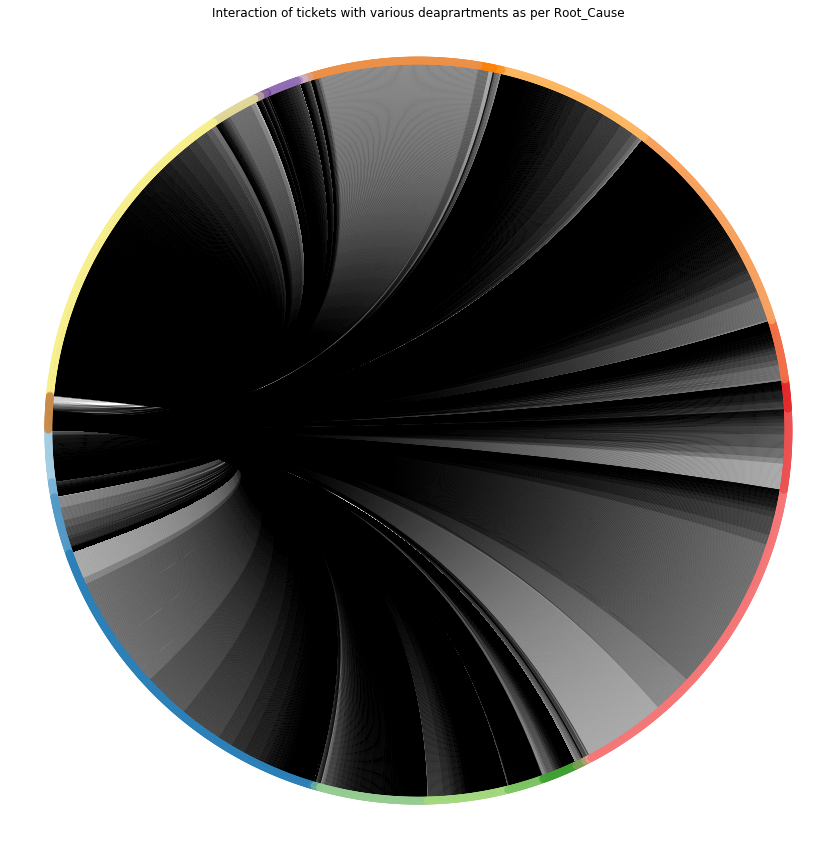

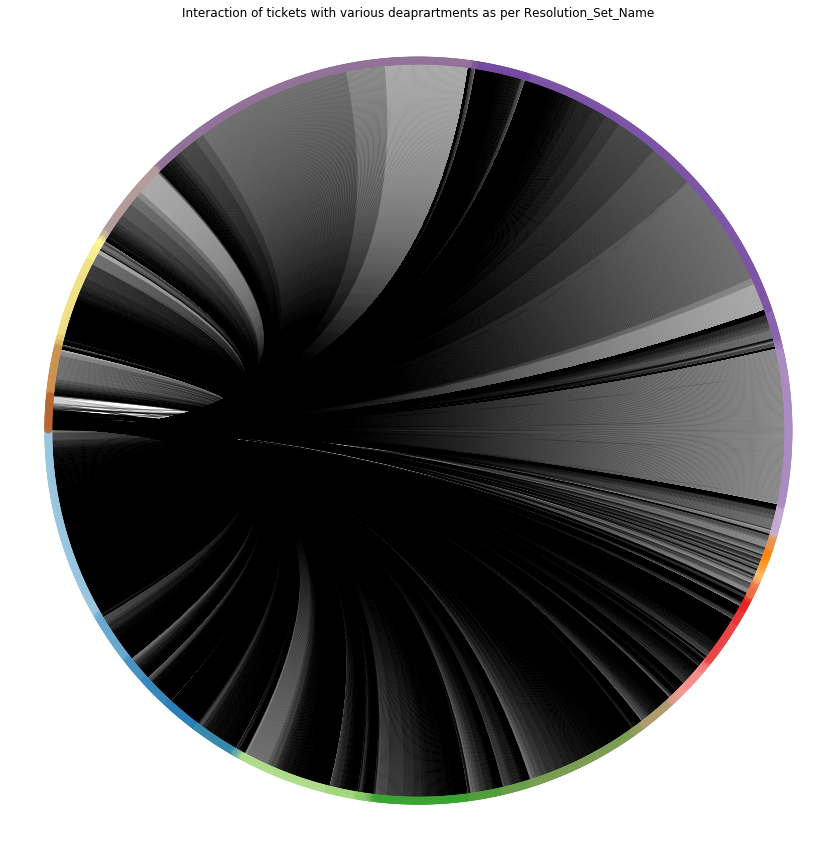

In [10]:
c_rc = nv.CircosPlot(ticket_graph,node_color='Root_Cause', node_grouping = 'Root_Cause',node_order = 'dc',figsize = (15,15) )
c_rc.draw()
plt.title("Interaction of tickets with various deaprartments as per Root_Cause")
plt.show()

c_sol_set = nv.CircosPlot(ticket_graph,node_color='Resolution_Set_Name', node_grouping = 'Resolution_Set_Name',node_order = 'dc',node_size = 'dc',edge_color= [n2 for n1,n2 in ticket_graph.edges()],node_labels=False,figsize = (15,15) )
c_sol_set.draw()
plt.title("Interaction of tickets with various deaprartments as per Resolution_Set_Name")
plt.show()




Top 5 departments to work on tickets with degree centrality: 
           org_name  degree_centrality
0      GU-GCSC-BVP          14.262136
1      US-GNMC-BVP           4.699029
2     MO-BGTN-VOIP           1.305825
3   IT-ENTRPRS-OPS           1.150943
4  IT-ENTRPRS-SDEL           0.849057


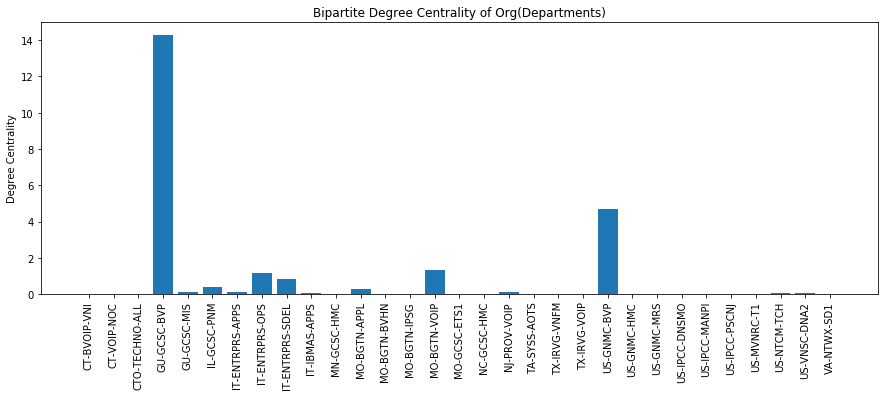

In [72]:
#top 5 orgs that work on tickets:
org_dc = pd.DataFrame(sorted([(n,ticket_graph.nodes[n]['dc']) for n,d in ticket_graph.nodes(data=True) if ticket_graph.nodes[n]['bipartite'] == 'org'],key = lambda x:x[1],reverse = True),columns = ['org_name','degree_centrality'])
print("Top 5 departments to work on tickets with degree centrality: \n",org_dc.head(5))

#bar charg comparison of bipartite degree centrality of all departments.
plt.figure(figsize = (15,5))
plt.bar(org_dc['org_name'],org_dc['degree_centrality'])
plt.title("Bipartite Degree Centrality of Org(Departments)")
plt.ylabel("Degree Centrality")
plt.xticks(rotation = 90 )
plt.show()

In [53]:
# Define get_nodes_and_nbrs()
def T_draw(G, attribute_name,attribute_value,fig_size = (10,10),node_labels = True):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
    nodes_of_interest = [n for n,d in [(n,d) for n,d in G.nodes(data=True) if attribute_name in G.node[n].keys()] if d[attribute_name]==attribute_value]
    
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
    
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
        
        # Iterate over all the neighbors of node n
        for nbr in G.neighbors(n):
        
            # Append the neighbors of n to nodes_to_draw
            nodes_to_draw.append(nbr)
    t_draw = G.subgraph(nodes_to_draw)
    
    # Draw the subgraph to the screen
    if len(t_draw.nodes) > 0:
        #overwriting bipartite degree-centrality to the node meta-data
        org_nodes = [n for n in t_draw.nodes if t_draw.nodes[n]['bipartite']== 'org']
        dcs = nx.bipartite.degree_centrality(t_draw,org_nodes)
        for k,v in dcs.items():
            t_draw.node[k]['dc'] = v
        org_nodes = pd.DataFrame([n for n in sorted([(n,t_draw.nodes[n]['dc']) for n in t_draw.nodes if t_draw.nodes[n]['bipartite']== 'org'],key = lambda x:x[1],reverse = True)],columns = ['org_name','dc_in_subgraph'])
        print("list of departments that work on tickets with {} = {} : \n {}".format(attribute_name,attribute_value,org_nodes))
                
        c_rc = nv.CircosPlot(t_draw,node_color='bipartite', node_grouping = 'bipartite',node_order = 'dc',figsize = fig_size, node_labels = node_labels)
        c_rc.draw()
        plt.title("Interaction of tickets with various deprartments as per {} = {}".format(attribute_name,attribute_value))
        plt.show()
        return t_draw
    else:
        print("There are no nodes with {} = {}.".format(attribute_name,attribute_value)) 


list of departments that work on tickets with Root_Cause = Application : 
           org_name  dc_in_subgraph
0     MO-BGTN-VOIP       40.094340
1   IT-ENTRPRS-OPS        1.150943
2  IT-ENTRPRS-SDEL        0.849057
3  IT-ENTRPRS-APPS        0.132075
4    IT-IBMAS-APPS        0.075472
5   CTO-TECHNO-ALL        0.018868


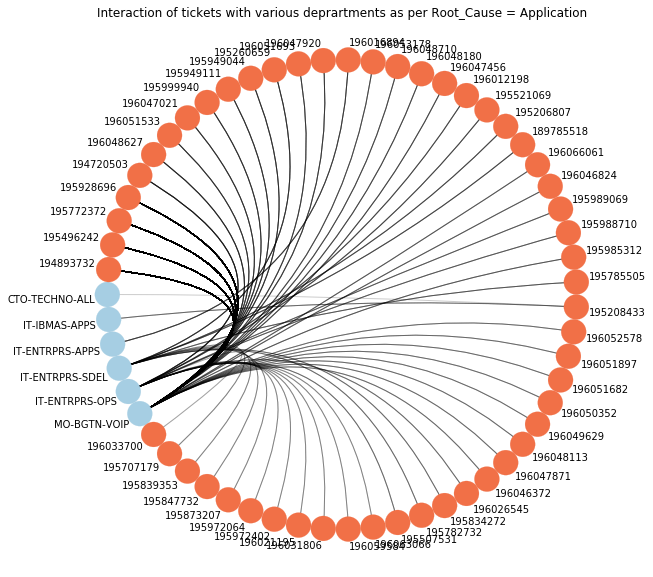

In [54]:
t_draw = T_draw(ticket_graph,'Root_Cause','Application')


list of departments that work on tickets with Root_Cause = Network : 
         org_name  dc_in_subgraph
0    GU-GCSC-BVP       14.262136
1    US-GNMC-BVP        4.699029
2   MO-BGTN-VOIP        1.305825
3    IL-GCSC-PNM        0.368932
4    GU-GCSC-MIS        0.111650
5    US-NTCM-TCH        0.067961
6   US-VNSC-DNA2        0.043689
7    US-GNMC-HMC        0.029126
8  US-IPCC-PSCNJ        0.024272


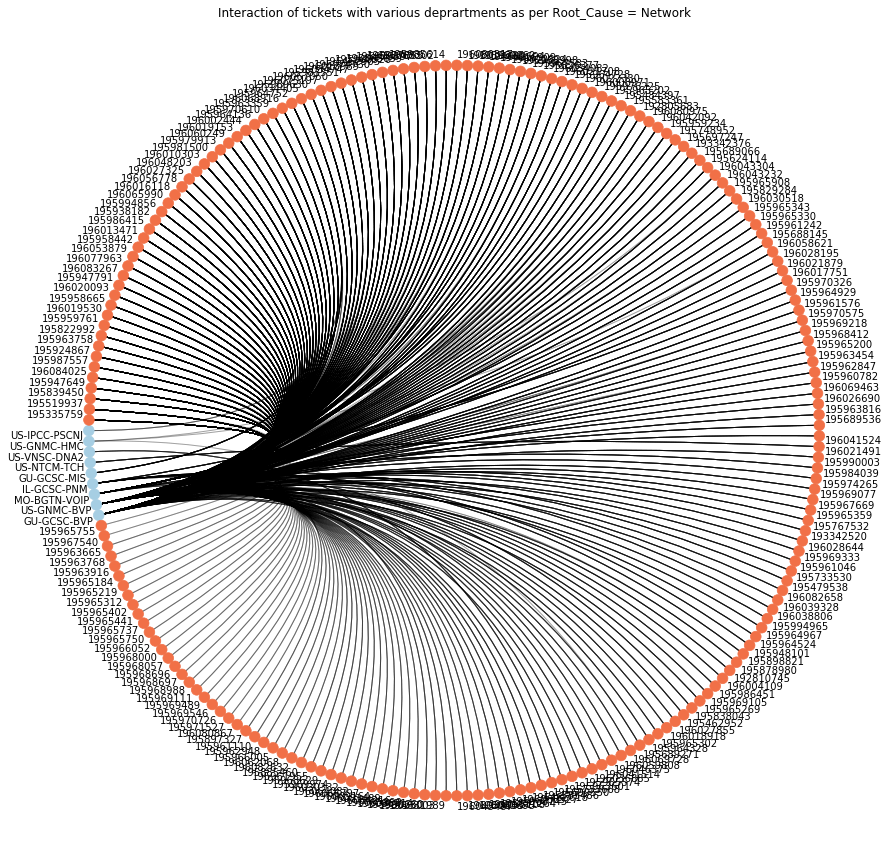

In [55]:
t_draw = T_draw(ticket_graph,'Root_Cause','Network',fig_size=(15,15))


## Model Training with  Problem Abstracts from tickets

In [190]:
def count_vector_model_nb(x,y):
    #Training Model with Counter_Vectorizer
    print("Results of Naive Bayes with count_vector_model:")
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.33, random_state = 42)
    
    # Initialize a CountVectorizer object: count_vectorizer
    count_vectorizer = CountVectorizer(stop_words = 'english')
    
    # Transform the training data using only the 'Problem_Extract' column values: count_train 
    count_train = count_vectorizer.fit_transform(X_train)
    
    # Transform the test data using only the 'Problem_Extract' column values: count_test 
    count_test = count_vectorizer.transform(X_test)
    
    # Create the CountVectorizer DataFrame: count_df
    count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

    alphas = np.arange(0.1,1,0.1)
    best_alpha = 0
    max_score = 0
    max_cm_df = pd.DataFrame()
    

    for alpha in alphas:
        
        # Create a Multinomial Naive Bayes classifier: nb_classifier
        nb_classifier = MultinomialNB(alpha = alpha)

        # Fit the classifier to the training data
        nb_classifier.fit(count_train,y_train)

        # Create the predicted tags: pred
        pred = nb_classifier.predict(count_test)

        # Calculate the accuracy score: score
        score = metrics.accuracy_score(y_test,pred)
        
        # Calculate the confusion matrix: cm
        y_labels = y_test.unique()
        cm = metrics.confusion_matrix(y_test,pred,y_labels)

        cm_df = pd.DataFrame(cm,columns=(y_labels)+"_Pred",index=(y_labels)+"_True")
        if score >= max_score:
            best_alpha = alpha
            max_score = score
            max_cm_df = cm_df
            model = nb_classifier
    
    print("Best_Alpha: %s | model_score: %s \n"%(best_alpha,max_score))
    # Get the class labels: class_labels
    class_labels = model.classes_
    
    # Extract the features: feature_names
    feature_names = tfidf_vectorizer.get_feature_names()
    
    # constructing dataframe with feature_weights
    feature_weights_df = pd.DataFrame(model.coef_.T,columns = class_labels,index = feature_names)
    feature_weights_df.index.name = "features"
    feature_weights_df.columns.name = y.name
    
    feature_weights_df
            
    return(best_alpha, max_score,max_cm_df,model,feature_weights_df)
            


In [191]:
def tfidf_vector_model_nb(x,y):
    #Training Model with tfidf_Vectorizer
    print("Results of Naive Bayes with tfidf_vector_model: ")
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(df["Problem_Abstract"],y,test_size = 0.33, random_state = 42)
    
    # Initialize a TfidfVectorizer object: tfidf_vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)

    # Transform the training data: tfidf_train 
    tfidf_train = tfidf_vectorizer.fit_transform(X_train)

    # Transform the test data: tfidf_test 
    tfidf_test = tfidf_vectorizer.transform(X_test)

       
    # Create the TfidfVectorizer DataFrame: tfidf_df
    tfidf_df = pd.DataFrame(tfidf_train.A,columns=tfidf_vectorizer.get_feature_names())
    
    alphas = np.arange(0.1,1,0.1)
    best_alpha = 0
    max_score = 0
    max_cm_df = pd.DataFrame()
    

    for alpha in alphas:
        
        # Create a Multinomial Naive Bayes classifier: nb_classifier
        nb_classifier = MultinomialNB(alpha = alpha)

        # Fit the classifier to the training data
        nb_classifier.fit(tfidf_train,y_train)

        # Create the predicted tags: pred
        pred = nb_classifier.predict(tfidf_test)

        # Calculate the accuracy score: score
        score = metrics.accuracy_score(y_test,pred)
        
        # Calculate the confusion matrix: cm
        y_labels = y_test.unique()
        cm = metrics.confusion_matrix(y_test,pred,y_labels)

        cm_df = pd.DataFrame(cm,columns=(y_labels)+"_Pred",index=(y_labels)+"_True")
        if score >= max_score:
            best_alpha = alpha
            max_score = score
            max_cm_df = cm_df
            model = nb_classifier
    
    print("Best_Alpha: %s | model_score: %s \n"%(best_alpha,max_score))
    # Get the class labels: class_labels
    class_labels = model.classes_
    
    # Extract the features: feature_names
    feature_names = tfidf_vectorizer.get_feature_names()
    
    # constructing dataframe with feature_weights
    feature_weights_df = pd.DataFrame(model.coef_.T,columns = class_labels,index = feature_names)
    feature_weights_df.index.name = "features"
    feature_weights_df.columns.name = y.name
    
    feature_weights_df
            
    return(best_alpha, max_score,max_cm_df,model,feature_weights_df)
            


In [274]:
def tfidf_vector_model_rf(x,y):
    #Training Model with tfidf_Vectorizer
    print("Results of RandomForest with tfidf_vector_model: ")
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.33, random_state = 42)
    
    # Initialize a TfidfVectorizer object: tfidf_vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)

    # Transform the training data: tfidf_train 
    tfidf_train = tfidf_vectorizer.fit_transform(X_train)

    # Transform the test data: tfidf_test 
    tfidf_test = tfidf_vectorizer.transform(X_test)

       
    # Create the TfidfVectorizer DataFrame: tfidf_df
    tfidf_df = pd.DataFrame(tfidf_train.A,columns=tfidf_vectorizer.get_feature_names())
    
    n_estimators = np.arange(100,1000,100)
    best_nestimators = 0
    max_score = 0
    max_cm_df = pd.DataFrame()
    
    for n in n_estimators:
        
        # Create a Multinomial Naive Bayes classifier: nb_classifier
        rf_classifier = RandomForestClassifier(n_estimators = n)

        # Fit the classifier to the training data
        rf_classifier.fit(tfidf_train,y_train)

        # Create the predicted tags: pred
        pred = rf_classifier.predict(tfidf_test)

        # Calculate the accuracy score: score
        score = metrics.accuracy_score(y_test,pred)
        
        # Calculate the confusion matrix: cm
        y_labels = y_test.unique()
        cm = metrics.confusion_matrix(y_test,pred,y_labels)

        cm_df = pd.DataFrame(cm,columns=(y_labels)+"_Pred",index=(y_labels)+"_True")
        if score >= max_score:
            best_nestimators = n
            max_score = score
            max_cm_df = cm_df
            model = rf_classifier
            vectorizer = tfidf_vectorizer
    
    
    
    print("Best_nEstimators: %s | model_score: %s \n"%(best_nestimators,max_score))
    # Get the class labels: class_labels
    class_labels = model.classes_
    
    # Extract the features: feature_names
    feature_names = tfidf_vectorizer.get_feature_names()
    
    # constructing dataframe with feature_weights
    feature_weights_df = pd.DataFrame(model.feature_importances_,index = feature_names,columns = ['weight'])
    feature_weights_df.index.name = "features"
    feature_weights_df = feature_weights_df.sort_values(by='weight', ascending=False)
    
            
    return(best_nestimators, max_score,max_cm_df,model,vectorizer,feature_weights_df)
            


In [192]:
#Predicting "Ticket_Type_Desc_Tx" for given Problem_Abstract
df = pd.read_csv("ticket_resolution.csv")

# Create a series to store the labels: y
x = df["Problem_Abstract"]
y = df.Ticket_Type_Desc_Tx

alpha, score, cm_df, model,feature_weights_df = count_vector_model_nb(x,y)
#alpha, score, cm_df, model,feature_weights_df = tfidf_vector_model_nb(x,y)
feature_weights_df[-20:]

Results of Naive Bayes with count_vector_model:
Best_Alpha: 0.9 | model_score: 0.8968023255813954 



Ticket_Type_Desc_Tx,Auto Detect,Client,Release,Web,e-Bonding
features,,,,,
webrtc,-7.623741,-8.676132,-7.809812,-8.003846,-7.805293
websphere,-7.517257,-8.676132,-7.809812,-8.003846,-7.805293
wed,-9.167938,-8.676132,-7.809812,-8.003846,-7.805293
week,-9.915153,-8.676132,-7.809812,-7.256631,-7.805293
wholesale_amalgam2133,-9.167938,-8.676132,-7.809812,-8.003846,-7.805293
wi,-9.915153,-7.928918,-7.809812,-8.003846,-7.805293
wipm_npe_citypairedgeclear,-9.167938,-8.676132,-7.809812,-8.003846,-7.805293
wipm_npe_snrcedgeclear,-9.167938,-8.676132,-7.809812,-8.003846,-7.805293
wlan0,-9.167938,-8.676132,-7.809812,-8.003846,-7.805293


In [272]:
#Predicting "Root_Cause_Desc_Tx" for given Problem_Abstract
df = pd.read_csv("ticket_resolution.csv")

# Create a series to store the labels: y
x = df["Problem_Abstract"]
y = df.Root_Cause_Desc_Tx

# alpha, score, cm_df, model,feature_weights_df = count_vector_model(x,y)
alpha, score, cm_df, model,feature_weights_df = tfidf_vector_model_nb(x,y)
feature_weights_df[-20:]

Results of Naive Bayes with tfidf_vector_model: 
Best_Alpha: 0.1 | model_score: 0.6584302325581395 



Root_Cause_Desc_Tx,AT&T Facilities,AT&T Provisioning,Application,Came Clear,Config Change,Configuration,Customer / Equipment,Data Alert,Environment,Environmental,Hardware,Human Error,INFO,Interfacing Application,Known Issue,Maintenance,Misdirect,NMS Monitoring,NTF,Network,No Trouble Found,Not Applicable,Not in Production,ORT/UAT/NVT,Other,Procedural,Provisioning,Resolved,Router,Router Config,Scheduled Project,System Software,Task Assigned,Unknown,Vendor Hardware/Software
features,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
webrtc,-8.161789,-7.896705,-8.182885,-9.295658,-7.822414,-7.857709,-8.352051,-8.297618,-7.989165,-7.814033,-8.083711,-7.883991,-7.852809,-7.819341,-9.239884,-8.387413,-7.945262,-7.817517,-8.151203,-8.664048,-8.544168,-7.816469,-7.85615,-7.913525,-8.417499,-7.855466,-7.843321,-7.829039,-7.951084,-7.818065,-7.852315,-7.862965,-4.976963,-8.912363,-7.819136
websphere,-8.161789,-7.896705,-8.182885,-6.484450,-7.822414,-7.857709,-8.352051,-8.297618,-7.989165,-7.814033,-8.083711,-7.883991,-7.852809,-7.819341,-9.239884,-8.387413,-7.945262,-7.817517,-8.151203,-8.664048,-8.544168,-7.816469,-7.85615,-7.913525,-8.417499,-7.855466,-7.843321,-7.829039,-7.951084,-7.818065,-7.852315,-7.862965,-8.099022,-8.912363,-7.819136
wed,-8.161789,-7.896705,-7.131218,-9.295658,-7.822414,-7.857709,-8.352051,-8.297618,-7.989165,-7.814033,-8.083711,-7.883991,-7.852809,-7.819341,-9.239884,-8.387413,-7.945262,-7.817517,-8.151203,-8.664048,-8.544168,-7.816469,-7.85615,-7.913525,-8.417499,-7.855466,-7.843321,-7.829039,-7.951084,-7.818065,-7.852315,-7.862965,-8.099022,-8.912363,-7.819136
week,-8.161789,-7.896705,-8.182885,-9.295658,-7.822414,-7.857709,-8.352051,-8.297618,-7.989165,-7.814033,-8.083711,-7.883991,-7.852809,-7.819341,-9.239884,-8.387413,-7.945262,-7.817517,-8.151203,-8.664048,-8.544168,-7.816469,-7.85615,-7.913525,-8.417499,-7.855466,-7.843321,-7.829039,-7.951084,-7.818065,-7.852315,-6.058847,-8.099022,-8.912363,-7.819136
wholesale_amalgam2133,-8.161789,-7.896705,-8.182885,-9.295658,-7.822414,-7.857709,-8.352051,-8.297618,-7.989165,-7.814033,-8.083711,-7.883991,-7.852809,-7.819341,-9.239884,-8.387413,-7.945262,-7.817517,-8.151203,-8.664048,-8.544168,-7.816469,-7.85615,-7.913525,-8.417499,-7.855466,-7.843321,-7.829039,-7.951084,-7.818065,-7.852315,-7.862965,-6.835769,-8.912363,-7.819136
wi,-8.161789,-7.896705,-8.182885,-9.295658,-7.822414,-7.857709,-8.352051,-8.297618,-7.989165,-7.814033,-8.083711,-7.883991,-6.771663,-7.819341,-9.239884,-8.387413,-7.945262,-7.817517,-8.151203,-8.664048,-8.544168,-7.816469,-7.85615,-7.913525,-8.417499,-7.855466,-7.843321,-7.829039,-7.951084,-7.818065,-7.852315,-7.862965,-8.099022,-8.912363,-7.819136
wipm_npe_citypairedgeclear,-8.161789,-7.896705,-8.182885,-9.295658,-7.822414,-7.857709,-8.352051,-8.297618,-7.989165,-7.814033,-8.083711,-7.883991,-7.852809,-7.819341,-9.239884,-7.421246,-7.945262,-7.817517,-8.151203,-8.664048,-8.544168,-7.816469,-7.85615,-7.913525,-8.417499,-7.855466,-7.843321,-7.829039,-7.951084,-7.818065,-7.852315,-7.862965,-8.099022,-8.912363,-7.819136
wipm_npe_snrcedgeclear,-8.161789,-7.896705,-8.182885,-9.295658,-7.822414,-7.857709,-8.352051,-8.297618,-7.989165,-7.814033,-8.083711,-7.883991,-7.852809,-7.819341,-9.239884,-7.175243,-7.945262,-7.817517,-8.151203,-8.664048,-8.544168,-7.816469,-7.85615,-7.913525,-8.417499,-7.855466,-7.843321,-7.829039,-7.951084,-7.818065,-7.852315,-7.862965,-8.099022,-8.912363,-7.819136
wlan0,-8.161789,-7.896705,-8.182885,-9.295658,-7.822414,-7.857709,-6.852837,-8.297618,-7.989165,-7.814033,-8.083711,-7.883991,-7.852809,-7.819341,-9.239884,-8.387413,-7.945262,-7.817517,-8.151203,-8.664048,-8.544168,-7.816469,-7.85615,-7.913525,-8.417499,-7.855466,-7.843321,-7.829039,-7.951084,-7.818065,-7.852315,-7.862965,-8.099022,-8.912363,-7.819136


In [275]:
#Predicting "Root_Cause" for given Problem_Abstract
df = pd.read_csv("ticket_resolution.csv")

# Create a series to store the labels: y
x = df["Problem_Abstract"]
y = df.Root_Cause_Desc_Tx

# alpha, score, cm_df, model,feature_weights_df = count_vector_model(x,y)
n_estimators, score, cm_df, model,vectorizer,feature_weights_df = tfidf_vector_model_rf(x,y)
feature_weights_df[0:20]

Results of RandomForest with tfidf_vector_model: 
Best_nEstimators: 700 | model_score: 0.6686046511627907 



,weight
features,
test,0.030168
voip,0.029590
ruby,0.026691
description,0.014987
2015,0.012663
01,0.012419
28,0.010485
internet,0.008932
router,0.008438


In [193]:
#Predicting "Resolution_Set_Name" for given Problem_Abstract
df = pd.read_csv("ticket_resolution.csv")

# Create a series to store the labels: y
x = df["Problem_Abstract"]
y = df.Resolution_Set_Name


alpha, score, cm_df, model_1,feature_weights_df = tfidf_vector_model_nb(x,y)
feature_weights_df[-20:]

Results of Naive Bayes with tfidf_vector_model: 
Best_Alpha: 0.1 | model_score: 0.5973837209302325 



Resolution_Set_Name,Application - Provided Information,BVOIP 2100 AT&T Brief Hit/Came Clear 2104,BVOIP 2100 Call Tree Software/Configuration 2132,BVOIP 2100 Configuration Issues 2102,BVOIP 2100 Customer Issue 2106,BVOIP 2100 Customer PBX Failure,BVOIP 2100 Informational/Provided Information 2122,BVOIP 2100 LEC or PTT Standard Outage 2112,BVOIP 2100 PBX/LAN/CPE Power Outage 2108,BVOIP 2100 Pbx/Lan/Cpe Hardware Issue 2111,BVOIP 2100 Pbx/Lan/Cpe Other 2115,BVOIP 2100 Pbx/Lan/Cpe Reboot 2114,BVOIP 2100 Router VoIP Router/Card Failure 2129,BVOIP 2100 Router VoIP Software/Configuration 2130,BVOIP 2100 Schedule Change 2139,BVOIP 2100 Sip Device Software/Configuration 2137,BVOIP 2100 Transport Circuit Failure 2119,BVOIP 3100 AT&T Brief Hit/Came Clear 2104,BVOIP 3100 Configuration Issue 2102,BVOIP 3100 Enhanced/Portal Access Customer 2142,BVOIP 3100 Fraud Referral/Customer Report 2144,BVOIP 3100 IPCAS Software Config/Hunt Group 2123,BVOIP 3100 IPCAS Software Config/Other 2128,BVOIP 3100 Informational/Provided Information 2122,BVOIP 3100 MACD: Move/Add/Change/Delete 2117,BVOIP 3100 Misdirected Call/Non-Provisioning 2145,BVOIP 3100 Misdirected Call/Provisioning 2146,BVOIP 3100 No Trouble Found 2101,BVOIP 3100 PBX/LAN/CPE Hardware Issue 2111,BVOIP 3100 PBX/LAN/CPE Other 2115,BVOIP 3100 PBX/LAN/CPE Power Outage 2108,BVOIP 3100 PBX/LAN/CPE Software Issue 2112,BVOIP 3100 Router VoIP Router Card Failure 2129,BVOIP 3100 Router VoIP Software Configuration 2130,BVOIP 3100 Router Voip Rebooted 2131,BVOIP 3100 SIP Device Rebooted 2138,BVOIP 3100 SIP Device Software/Configuration 2137,BVOIP 3100 Translation/TN Porting Errors 2148,BVOIP 3100 Transport Circuit Failure 2119,Bvoip 2100 No Trouble Found 2101,Bvoip 2100 Misdirected Call 2121,CPE Conf Updated,GT3 - Configuration,GT3 - Core Issue,HD - Application Data,HD - Application Design,HD - Application Fault,HD - DB Update,HD - Human Error Fault,HD - Input Error,HD - Interfacing Application Fault,HD - NTF,HD - Procedural Fault,HD - Process Fault,HD - Unknown Fault,HD - Workaround,Hardware - Application Related Problem,Hardware - Element is not in Production,Hardware - Known Issue,Hardware - Resolved,IP Tel Scheduled Maintenance - 1104,ISP - Issue Cleared,Networking - Duplicate Ticket,Networking - Not a Networking Issue,Networking - Task Completed,Other - 22 Informational/Provided Information,Procedural - People 1,TA Auto Closure 8000 - Came Clear (CC/01),Toll Free Number-Informational,UnKnown,VoIP - Application/Software,VoIP - Came Clear,VoIP - Core T1/T3 Issue,VoIP - Fraud Request - Block/UnBlock Restrictions,VoIP - Hardware Reset,VoIP - Known Issue,VoIP - Loopback/Telemetry Failure - Came Clear,VoIP - Maintenance,VoIP - Network,VoIP - Network - No trouble was found,VoIP - No Trouble Found,VoIP - Not in Production,VoIP - ORT Operational Readiness Testing,VoIP - PMOSS/Bundle Alert,VoIP - Provisioning,VoIP - Resolved,VoIP - Single or Multiple CIC Reset/Restorals,VoIP - Task Completed,VoIP - Vendor
features,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
webrtc,-7.814929,-8.641472,-7.808786,-7.821505,-8.035721,-7.821078,-7.954946,-8.033821,-7.989165,-7.813916,-8.084673,-7.814552,-7.823742,-7.822300,-7.813922,-7.815536,-8.19624,-8.002170,-7.869646,-7.814155,-7.824137,-7.813515,-7.815536,-8.267221,-7.830172,-7.998828,-7.945262,-8.278322,-7.882641,-8.014202,-7.814033,-7.856116,-7.858403,-7.923691,-7.833880,-7.826691,-7.815536,-7.813638,-8.059155,-7.873232,-7.850617,-7.835566,-7.818065,-7.814368,-7.829422,-7.810055,-7.820456,-7.803027,-7.835394,-7.821022,-7.819341,-7.821233,-7.855466,-7.819341,-7.819907,-7.855469,-7.820188,-7.81923,-7.824243,-7.939136,-7.815006,-7.817517,-7.815965,-7.816469,-7.829039,-7.973023,-7.819714,-8.383048,-7.852809,-7.823817,-8.099331,-9.292824,-8.161789,-7.808752,-7.875513,-9.234775,-7.839656,-8.387413,-7.860276,-7.81923,-7.814155,-7.840539,-7.913525,-8.297618,-7.843321,-7.827086,-7.816767,-4.976963,-7.819136
websphere,-7.814929,-8.641472,-

In [265]:
#Predicting "Resolution_Set_Name" for given Problem_Abstract
df = pd.read_csv("ticket_resolution.csv")

# Create a series to store the labels: y
x = df["Problem_Abstract"]
y = df.Resolution_Set_Name

# alpha, score, cm_df, model,feature_weights_df = count_vector_model(x,y)
n_estimators, score, cm_df, model,vectorizer,feature_weights_df = tfidf_vector_model_rf(x,y)
feature_weights_df[0:20]

Results of RandomForest with tfidf_vector_model: 
Best_nEstimators: 300 | model_score: 0.627906976744186 



,weight
features,
ruby,0.029073
voip,0.028905
test,0.024606
description,0.014564
01,0.013172
2015,0.012532
28,0.012352
router,0.008913
internet,0.007991


In [276]:
model.predict(vectorizer.transform(pd.Series(df["Problem_Abstract"][0])))

array(['Application'], dtype=object)